In [20]:
#import matplotlib as matplot
#import seaborn
#import bokeh
#import keras
#import scipy
import pandas as pd
import numpy as np
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
import graphviz
from ncs1_import import ncs1_data
from ncsr_import import ncsr_data
import re
import pathpy as pp
import matplotlib.pyplot as plt
# For color mapping
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.lines as mlines
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
# import block

In [2]:
#ncs1 = ncs1_data()
ncsr = ncsr_data()
  # ncs1 holds all of the data from NCS 006693
  # Includes ncs1.dxdm (DS0002 DataFrame) and ncs1.survey (DS001 DataFrame)
  # Key Functions:
    # ncs1.search_for_description looks for a descriotion of a column name in ncs1.dxdm or ncs1.survey
  # Key Variables:
    # ncs1.dxdm (DS0002)
    # ncs1.survey (DS0001)
    # ncs1.tree (Tree including descriptions of survey and dxdm columns)
    # ncs1.root (root used in traversing ncs1.tree)

In [3]:
a = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])
b = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])
c = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])

for x in range(1, len(ncsr.root)):
    a = a.append(
        ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
            np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(first|1st|onset)+.*", False)) & np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(^Age |^Age| age | age|age )+.*", False)) & np.logical_not(np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(^Remember|^Exact)+.*", False)))
            ]
    )
   ## 
    #b = b.append(
   #     ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #         np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #             'Description'].str.match(".*(first|1st|onset)+.*", False)) & np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #                 'Description'].str.match(".*(^Age |^Age| age | age|age | old|old | old |^DSM|^ICD)+.*", False))
   #         ]
   # )
   # c = c.append(
   #     ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #         np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(first|1st|onset)+.*", False))
   #         ]
   # )
   # pd.concat([,c]).drop_duplicates(keep=False).to_csv('out.csv')

a = a.reset_index(drop=True)

a.to_csv('time_series_vars_ncs2.csv')


In [53]:
a = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])
b = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])
c = pd.DataFrame(columns = ['VarName', 'Description', 'Root_DF', 'Start', 'End', 'DataFrame', 'recursion_flag'])

for x in range(1, len(ncsr.root)):
    a = a.append(
        ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
            np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*.*", False)) & np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(^Age |^Age| age )+.*", False)) & np.logical_not(np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(^Remember|^Exact|^Age$|#|biological)+.*", False)))
            ]
    )
   ## 
    #b = b.append(
   #     ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #         np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #             'Description'].str.match(".*(first|1st|onset)+.*", False)) & np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #                 'Description'].str.match(".*(^Age |^Age| age | age|age | old|old | old |^DSM|^ICD)+.*", False))
   #         ]
   # )
   # c = c.append(
   #     ncsr.get_value_from_string(ncsr.root.iloc[x,0])[
   #         np.array(ncsr.get_value_from_string(ncsr.root.iloc[x,0])['Description'].str.match(".*(first|1st|onset)+.*", False))
   #         ]
   # )
   # pd.concat([,c]).drop_duplicates(keep=False).to_csv('out.csv')

a = a.reset_index(drop=True)

a.to_csv('time_series_vars_ncsr-justage.csv')


For above ^ chose the filter based on a staged approach identifying variables that had ages and whittlling it down checking with concat()

In [54]:
#a.loc[(a.loc[(a.loc[:,"Start"]< 3713), "Start"]>3369), :]
#https://www.kaggle.com/anand0427/network-graph-with-at-t-data-using-plotly

In [99]:
y = 534
current_case = y
varlist_444 = []
for x in a.iloc[:, 0]: 
    if ncsr.ncsr.loc[y, x] != ' ':
        if ncsr.ncsr.loc[y, x] != '.' and int(ncsr.ncsr.loc[y,x]) > 1 and int(ncsr.ncsr.loc[y,x]) < 100:
              varlist_444.append(x)
print(len(varlist_444))

53


In [100]:
vals = list(ncsr.ncsr.loc[current_case, varlist_444])
vals = [int(i) for i in vals]
ordered_vals =[]
ordered_vars = []

for x in range(0, len(vals)):
    m = vals.index(min(vals))
    ordered_vals.append(vals[m])
    ordered_vars.append(varlist_444[m])
    del vals[m]
    del varlist_444[m]

In [101]:
node_info = {}
for x in range(0, len(ordered_vals)):
    node_info[x] = ncsr.search_for_description(ordered_vars[x])[1] + " - " + str(ordered_vals[x])

G = nx.DiGraph()
for x in range(0, len(ordered_vals)):
    G.add_node(ordered_vars[x], age = ordered_vals[x])
flag = 1
back_start = -1
back_flag = 0
start = -1
for x in range(1, len(ordered_vars)):
    print(ordered_vars[x], flag, start, back_flag,  back_start)
    print(ordered_vals[x], ordered_vals[x-1])
    if ordered_vals[x-1] != ordered_vals[x] and flag == 1:
        if back_flag: 
            for y in range(back_start, x):
                #print("G.add_edges_from([(ordered_vars["+str(y)+"], ordered_vars["+str(x)+"])])")
                G.add_edges_from([(ordered_vars[y], ordered_vars[x])])
        else: 
            G.add_edges_from([(ordered_vars[x-1], ordered_vars[x])])
        back_start=start
        start = x
        back_flag = 0
        flag = 1
    elif x + 1 == len(ordered_vals) and flag == 0:
        if back_flag:
            for y in range(back_start, start):
                for z in range(start, x):
                    G.add_edges_from([(ordered_vars[y], ordered_vars[z]), (ordered_vars[z], ordered_vars[x])])
        else:
            for y in range(start, x):
                G.add_edges_from([(ordered_vars[start], ordered_vars[y]), (ordered_vars[y], ordered_vars[x])])
        start = x
    elif x + 1 == len(ordered_vals) and flag == 1:
        if back_flag: 
            for y in range(back_start, x):
                G.add_edges_from([(ordered_vars[y], ordered_vars[x])])
        else: 
            G.add_edges_from([(ordered_vars[x-1], ordered_vars[x])])
        start =x
    elif ordered_vals[x-1] != ordered_vals[x] and start == -1: 
        start = x
        for y in range(0, x):
           G.add_edges_from([(ordered_vars[y], ordered_vars[x])])
        back_flag = 0
        back_start = 0
    elif ordered_vals[x-1] != ordered_vals[x] and flag == 0: 
        if back_flag:
            for y in range(back_start, start):
                for z in range(start, x):
                    G.add_edges_from([(ordered_vars[y], ordered_vars[z]), (ordered_vars[z], ordered_vars[x])])
        else:
            for y in range(start, x):
                G.add_edges_from([(ordered_vars[start], ordered_vars[y]), (ordered_vars[y], ordered_vars[x])])
        flag = 1
        back_start = start
        start = x
        back_flag = 1
    else:
        flag = 0
        

In [102]:
G = nx.DiGraph()
for x in range(0, len(ordered_vals)):
    G.add_node(ordered_vars[x], age = ordered_vals[x])
mult_flag = 0
back_start = -1
back_end = -1
back_flag = 0
start = 0
for x in range(0, len(ordered_vars)-1):
    if ordered_vals[x] != ordered_vals[x+1]:
        if not mult_flag:
            G.add_edges_from([(ordered_vars[x], ordered_vars[x+1])])
            back_flag = 0
        else: 
            for y in range(start, x+1):
                G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
                back_flag = 1
                back_end = x
        back_start = start
        start = x + 1
        mult_flag = 0
    elif ordered_vals[x] == ordered_vals[x+1]:
        mult_flag = 1
        if back_start<0:
            continue
        if back_flag: 
            for y in range(back_start, back_end + 1):
                G.add_edges_from([(ordered_vars[y], ordered_vars[x+1])])
        else:
            G.add_edges_from([(ordered_vars[back_start], ordered_vars[x+1])]) 


import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
#import pygraphviz
#pos = nx.drawing.nx_agraph.graphviz_layout(G)
#pos = nx.kamada_kawai_layout(G, pos = nx.spring_layout(G, k=3, iterations=10, dim=2, seed = 3))
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
G = nx.read_gpickle('graph.pkl')
pos = graphviz_layout(G, 'dot')
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=1,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])



node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        #reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=10,
            title='Age',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])


for x in G.nodes(data = True):
    node_trace['marker']['color']+=tuple([x[1]['age']])
    node_info = x[0] +' Age: '+str(x[1]['age'])
    node_trace['text']+=tuple([node_info])


fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network for CASEID 445',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)


<Figure size 432x288 with 0 Axes>

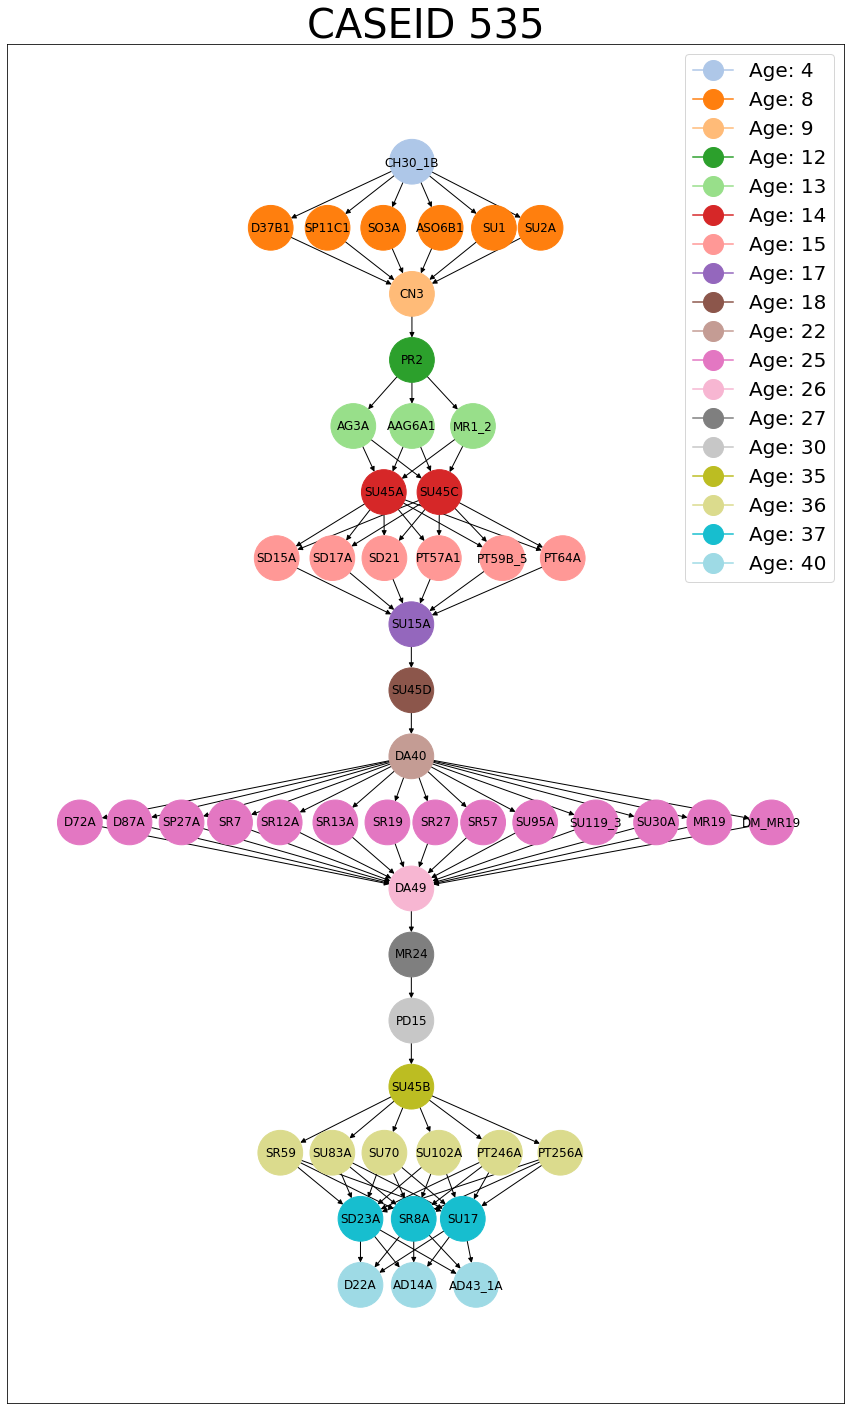

In [103]:
#G = nx.read_gpickle('graph.pkl')
pos = graphviz_layout(G, prog="dot")
levels = []
for x in ordered_vars:
    try:
        levels.append((len(nx.shortest_path(G, source=ordered_vars[0], target=x))))
    except: 
        levels.append(1)
col = cm = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=max(levels))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=col)
plt.set_cmap(col)
f = plt.figure(3, figsize=(15,25))
nx.draw_networkx(G, pos, node_color=levels, node_size= 2000, vmax = max(levels), vmin = 0)
ax = []
for x, val in enumerate(set(levels)):
    ax.append(mlines.Line2D([], [], color=scalarMap.to_rgba(val), label = "Age: " + str(ordered_vals[levels.index(val)]), marker="o", markersize=20))
plt.legend(prop={'size': 20}, handles = ax)
plt.title("CASEID " + str(current_case + 1), fontsize = 40)
plt.savefig('plots/case_' + str(current_case+1) + '.jpg', bbox_inches = 'tight')

In [52]:
ncsr.search_for_description("DA39gA")

VarName                                DA39A
Description       Age biological mother died
Root_DF                   Adult_Demographics
Start                                   2374
End                                     2374
DataFrame                               ncsr
recursion_flag                             0
Name: 19, dtype: object

In [99]:
len(levels)

57